<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/pharmacology1.jpg?raw=true' width='100%'>

# **BUSCA DE COMPOSTOS FARMACOLÓGICOS COM MECANISMO DE AÇÃO INIBIDOR**
##**Projeto Final - 3ª Imersão Dados Alura**

## **PREPARAÇÃO DOS DADOS**

### **Bases de Dados**

In [1]:
#Fontes de Dados
URL_experimentos = 'https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Dados/dados_experimentos.zip?raw=true'
URL_resultados = 'https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Dados/dados_resultados.csv?raw=true'

### **Importando as Bibliotecas**


In [2]:
#AUTOML
#!pip install pycaret

In [79]:
#bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.multiclass import type_of_target
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
#preprocessamento
from sklearn.model_selection import train_test_split
#modelos
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#métricas de avaliação
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

#AutoML
from pycaret.classification import *

sns.set()

### **Leitura das Bases de Dados**

In [4]:
#base de experimentos
experimentos = pd.read_csv(URL_experimentos, compression='zip')
#base de resultados
resultados = pd.read_csv(URL_resultados)

### **Funções**

In [67]:
#Função para calcular as features usando o RFECV
def selecao_features_por_modelo(X, y, modelo):
  """
  Usa a função SelectFromModel para a escolha de features, de acordo com os dados, o modelo, e a forma de avaliação.
  Retorna o gráfico por feature e um DataFrame com as colunas de X e se a feature é importante para o modelo escolhido

  Variáveis:
  X = Dataframe: São as variáveis explicativas
  y = Dataframe ou Series: A variável alvo
  modelo = um modelo de machine learning de classificação

  Retorno:
  colunas_a_manter = Dataframe contendo o rfecv.support_ e as colunas de X 


  """
  sfm = SelectFromModel(estimator=modelo)
  sfm.fit(X, y)

  

  colunas_a_manter = pd.DataFrame({'coluna':X.columns,
              'bool': sfm.get_support()})
  print(f"Optimal number of features :{ colunas_a_manter.query('bool == True').nunique()}")
  return colunas_a_manter

#Função para plotar correlação
def plota_correlacao(corr, annot = False):
  """
  Plota um Heatmap de correlação:
  Input:
  corr = Dataframe de correlação: normalmente representado pela função df.corr()
  annot = bool: Se quer que o heatmap venha com os valores ou não
  """
  plt.figure(figsize=(20,20))
  # Criando uma máscara para mostrar apenas os dados únicos do mapa de calor
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=annot, cmap='Blues', fmt = '.2f')

#FUNÇÃO QUE DIVIDE EM DADOS DE TREINO E TESTE USANDO NOSSAS CONFIGURAÇÕES PERSONALIZADAS
def divide_treino_teste(X,y):
  """
  Personaliza a função train_test_split do sklearn
  retorna X_train, X_test, y_train, y_test
  """
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=17714, stratify=y)
  return X_train, X_test, y_train, y_test

#função para avaliar o modelo com o classification report e matriz de correlação
def avalia_classificador(X_test, y_test, y_pred, modelo):
  """
  Classifica um modelo treinado, usando o classification report do sci-kit learn
  e plota a matriz de confusão

  Inputs:
  X_test: pd.Dataframe ou pd.Series - variáveis explicativas do dataframe de teste
  y_test: pd.Series ou Array - valores que o modelo pretente prever
  y_pred: pd.Series - previsões do modelo
  modelo: modelo de machine learning treinado com os dados de treino
  """
  print(classification_report(y_test,y_pred))
  plot_confusion_matrix(modelo, X_test, y_test);
  
#FUNÇÃO PARA TREINAR E AVALIAR MODELOS
def treina_e_avalia_classificador(modelo, x_treino, x_teste, y_treino, y_teste):
  """
  A partir de um modelo selecionado de classificação, 
  faz o ajuste e a previsão do modelo aos dados de treino, retornando o modelo treinado, 
  as previsões, e a avaliação dos dados de teste usando o classification report e a matriz de confusão.
  Depende da função avalia_classificador():

  Inputs:
  modelo:Objeto = Algoritmo de machine learning. Objeto do tipo modelo (que recebe X e Y como parâmetros, preferencialmente nesta ordem),
  É sugerido que o parâmetros random_state esteja definido entre os hiperparâmetros do modelo, se possível.
  Obrigatoriamente precisa conter os métodos fit() e predict()

  x_treino: pd.DataFrame ou pd.Series = São as variáveis explicativas de treino, para efetuar o ajuste do modelo
  x_teste: pd.Dataframe ou pd.Series - variáveis explicativas do dataframe de teste
  y_treino: pd.Series ou Array - variável alvo usada para treinar o modelo
  y_teste: pd.Series ou Array - valores que o modelo pretente prever

  Outputs:
  modelo_treinado = Um modelo de machine learning treinado com os dados de treino
  previsoes = o y_pred ou as previsões dos dados de teste
  Retorna também a avaliação do modelo
  """
  modelo_treinado = modelo.fit(x_treino, y_treino)
  previsoes = modelo_treinado.predict(x_teste)
  avaliacao = avalia_classificador(x_teste, y_teste, previsoes, modelo_treinado)
  return (modelo_treinado, previsoes,avaliacao)


# **INTRODUÇÃO**

### **A DESCOBERTA DE MEDICAMENTOS**

A **busca por medicamentos** para o alívio de sintomas e tratamento de doenças talvez seja uma das **práticas mais antigas da nossa sociedade**. 

A evidência escrita mais antiga de uso de plantas medicinais tem aproximadamente  5 mil anos: uma peça de argila escrita em sumério e que continha 12 receitas com mais de 250 plantas, dentre elas papoula, meimendro e mandrágora. Há também o livro chinês *“Pen T’Sao”*, escrito em 2.500 a.C, que trata de mais de 300 plantas as quais são usadas até hoje na medicina tradicional chinesa, como cânfora, ginseng e casca de canela. 
O vasto conhecimento acumulado que temos hoje sobre quais plantas podem ser venenosas, medicinais ou psicotrópicas se deve à sobrevivência desse conhecimento antigo, que hoje chamamos de **“conhecimento tradicional”**. Há também aqueles fármacos que foram descobertos por acaso, como é o caso da Penicilina, descoberta em 1928 por Alexander Fleming. 

Hoje a prospecção de novos fármacos se dá por meio de pesquisas científicas, as quais buscam isolar e purificar compostos de plantas, fungos e microorganismos, elaborar e testar compostos sintéticos ou até mesmo buscar por novas funções e aprimorar fármacos já conhecidos.   

As **pesquisas biomédicas** estão cada vez mais **interdisciplinares** e sofisticadas e os dados gerados nesses estudos são cada vez mais volumosos e complexos, tornando a **ciência de dados essencial no desenvolvimento da farmacologia**. 

Texto retirado e adaptado de :[Drug discovery: passado, presente e futuro](https://docs.google.com/document/d/10EhrQBChlyYIcff3to7PrCQi5HcNk2r-zd2ZCKPtcz8/edit)


###**EXPRESSÃO GÊNICA**

Toda informação necessária para construir e manter vivo um organismo está
guardada na molécula de DNA. Em cada célula humana, por exemplo, encontramos 46 moléculas de DNA, sendo 23 de origem materna e 23 de origem paterna. Nelas estão os genes, que é um trecho de DNA que contem a informação para a produção de proteínas - como insulina, hemoglobina, lactase e anticorpos -  e o ser humano possui aproximadamente 20 mil deles.

Como exemplo, o gene LCT que contém a receita para a síntese da
proteína lactase está no DNA, que fica dentro do núcleo da célula. Porém, o **ribossomo, que é a fábrica de proteínas da célula** fica fora do núcleo. Assim, a informação esta informação é copiada em uma molécula chamada **RNA que irá levar a receita da lactase do núcleo até o ribossomo** para que ele possa fabricar a proteína. Esse caminho da informação é o que chamamos de expressão gênica.


<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/expressao_genica.PNG?raw=true' alt='expressão gênica' height='400px'>

A regulação da expressão gênica é algo extremamente importante para o
bom funcionamento da célula e consequentemente do organismo, pois assim a célula é capaz de aumentar ou diminuir a síntese de proteínas de acordo com a necessidade. **Fatores internos (como o tipo celular, hormônios, fase do desenvolvimento) e externos (medicamentos, alimentação, raios solares e patógenos) influenciam e regulam a expressão dos genes**. 

Vejamos a imagem abaixo:

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/expressao_genica_2.PNG?raw=true' alt='expressão gênica'>

Suponhamos que o gene destacado em vermelho, em condições normais da
célula, produza 4 RNAs e, consequentemente, 4 proteínas. Esses são nossos valores de referência (ou controle). Porém, quando essa célula entra em contato com o composto 1, a expressão do gene passa de 4 para 8, ou seja, a expressão gênica dobrou em relação ao controle. Mas pode ser que um outro composto, o composto 2, reduza a expressão desse gene pela metade em relação ao controle, passando de 4 para 2. 

**Dessa forma, somos capazes de medir a expressão dos genes e regular a
síntese de RNA e proteínas por meio da administração de fármacos, por exemplo, para obtermos algum efeito terapêutico.**

Texto e imagens retirados e adaptados de [Expressão Gênica](https://drive.google.com/file/d/1VNP08ffCiGD8cqaBkdHATWSX8Yxfm3dj/view) 

Nossos dados contém uma série de experimentos com vários compostos e as medidas de seus efeitos em certos genes e tipos celulares. Temos também os resultados dos efeitos causados por estes compostos.

### **O PROJETO *CONNECTIVITY MAP* E NOSSOS DADOS**

o Connectivity Map, um projeto que engloba instituições como o MIT e Harvard nos apresentou a base de dados, com o desafio que tem por objetivo **avançar o desenvolvimento de medicamentos usando algoritmos de previsão dos mecanismos de ação de uma droga.**

#### **O QUE É MECANISMO DE AÇÃO (MoA) DE UMA DROGA?**

Após os avanços tecnológicos da farmacologia, hoje em dia, os cientistas buscam identificar uma proteína-alvo associada com uma doença e desenvolver uma molécula que possa modular essa proteína-alvo. **Para resumir a atividade biológica de uma dada molécula, os cientistas lhe deram o rótulo de Mecanismo de Ação, ou MoA (derivado do inglês)**.

#### **COMO SE DETERMINAM OS MOAS DE UMA NOVA DROGA**

Uma abordagem é tratar uma amostra de células humanas com o composto e analisar as respostas ceulares com algoritmos que buscam por similaridade para encontrar padrões em grandes datasets genômicos, tais como bibliotecas de expressão gênica ou padrões de viabilidade celular dos compostos com MoAs conhecidos. 

#### **NOSSOS DADOS**

Os dados a que temos acesso combina expressões gênicas e dados de viabilidade de células. Os dados se baseiam numa nova tecnologia que mede simultaneamente (numa amostra) as respostas aos medicamentos em 100 diferentes tipos de células (resolvendo o problema de identificar antecipadamente quais tipos celulares são melhores para um composto específico). Além disso, temos acesso às anotações de MOA de aproximadamente 5000 compostos.

O desafio do Kaggle de onde tiramos os dados é criar um classificador multilabel que determine os compostos que ativam uma ou mais de uma classe de MOA. A ideia seria determinar quais os MoAs ativados por um composto, a partir de sua assinatura genética.

No entanto, devido à escassez de tempo para a confecção deste projeto, nosso escopo será reduzido.

Fonte: [Kaggle](https://www.kaggle.com/c/lish-moa/overview/description)



## **ESCOPO DO PROJETO**

O Escopo definido para este projeto foi um mecanismo específico de ação de um composto, no caso os mecanismos inibidores. Segundo o trabalho [Enzyme Inhibition: Mechanisms and Scope](https://cdn.intechopen.com/pdfs/36550/InTech-Enzyme_inhibition_mechanisms_and_scope.pdf) de Rakesh Sharma, os inibidores de enzima são compostos químicos de baixo peso molecular que reduzem ou inibem completamente a atividade catalisadora da enzima, seja de forma reversível ou permanente. O inibidor pode alterar um aminoácido, ou várias cadeias laterais requeridas pela atividade catalisadora da enzima. 

Ainda no mesmo estudo, Sharma nos lembra que no processo de descoberta de medicamentos, vários compostos são criados com o propósito de inibir enzimas específicas, ainda que haja outros mecanismos (como antitoxinas) que tenham ação semelhante. A descoberta de novos inibidores era feita totalmente manualmente, por tentativa e erro, numa busca por uma extensiva biblioteca de compostos. Nosso estudo tem por objetivo automatizar parte do processo, auxiliando cientistas a definir se um composto gera algum mecanismo de ação inibidor, para separá-lo dos mais de 30 tipos de mecanismos de ação, reduzindo o escopo de uma pesquisa.

## **ANÁLISES INICIAIS**

In [6]:
#conhecendo os dados
experimentos.head()

id tratamento  tempo dose      droga     g-0     g-1     g-2  \
0  id_000644bb2  com_droga     24   D1  b68db1d53  1.0620  0.5577 -0.2479   
1  id_000779bfc  com_droga     72   D1  df89a8e5a  0.0743  0.4087  0.2991   
2  id_000a6266a  com_droga     48   D1  18bb41b2c  0.6280  0.5817  1.5540   
3  id_0015fd391  com_droga     48   D1  8c7f86626 -0.5138 -0.2491 -0.2656   
4  id_001626bd3  com_droga     72   D2  7cbed3131 -0.3254 -0.4009  0.9700   

      g-3     g-4     g-5     g-6     g-7     g-8     g-9    g-10    g-11  \
0 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530   
1  0.0604  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201   
2 -0.0764 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631   
3  0.5288  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584   
4  0.6919  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121   

     g-12    g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20  \
0  0.5574 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688   
1 -0.0958  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449   
2 -0.0366 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799   
3 -0.8511 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200   
4 -0.9577  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330   

     g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29  \
0 -1.1360 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819   
1 -0.1646 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161   
2 -0.8181 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870   
3 -1.1580 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890   
4 -0.2685  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965   

     g-30    g-31    g-32    g-33    g-34    g-35    g-36    g-37    g-38  \
0  0.2934 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119   
1 -0.0499 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568   
2 -1.8530  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470   
3 -0.7575  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900   
4 -0.0712  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888   

     g-39    g-40    g-41    g-42    g-43    g-44    g-45    g-46    g-47  \
0 -0.2162 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251   
1 -0.0455  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615   
2  1.0310  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615   
3 -0.3814 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747   
4 -0.0848  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416   

     g-48    g-49    g-50    g-51    g-52    g-53    g-54    g-55    g-56  \
0  0.0350  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750   
1  0.1710 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328   
2 -0.4983  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540   
3 -0.4851  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936   
4 -0.3780 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180   

     g-57    g-58    g-59    g-60    g-61    g-62    g-63    g-64    g-65  \
0  0.2263  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251   
1  0.4759  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948   
2  0.0621 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280   
3  0.4331  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977   
4  1.2130  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392   

     g-66    g-67    g-68    g-69    g-70    g-71    g-72    g-73    g-74  \
0  0.1670 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406   
1 -0.8026  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008   
2 -0.0292  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708   
3

In [7]:
resultados.head()

id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  adrenergic_receptor_agonist  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   adrenergic_receptor_antagonist  akt_inhibitor  \
0                               0              0   
1                               0              0   
2                               0              0   
3                               0              0   
4                               0              0   

   aldehyde_dehydrogenase_inhibitor  alk_inhibitor  ampk_activator  analgesic  \
0                                 0              0               0          0   
1                                 0              0               0          0   
2                                 0              0               0          0   
3                                 0              0               0          0   
4                                 0              0               0          0   

   androgen_receptor_agonist  androgen_receptor_antagonist  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   anesthetic_-_local  angiogenesis_inhibitor  \
0                   0                       0   
1                   0                       0   
2                   0                       0   
3                   0                       0   
4                   0                       0   

   angiotensin_receptor_antagonist  anti-inflammatory  antiarrhythmic  \
0                                0                  0               0   
1                                0                  0               0   
2                                0                  0               0   
3                                0                  0               0   
4                                0                  0               0   

   antibiotic  anticonvulsant  antifungal  antihistamine  antimalarial  \
0           0               0           0              0             0   
1           0  

In [8]:
#alterando as colunas do dataset de experimentos, para que não conste o hífen no nome das colunas
experimentos.columns = experimentos.columns.str.replace('-','')


In [9]:
#separando apenas as colunas com MOA inibidores
inibidores = resultados.loc[:,resultados.columns.str.contains('inhibitor')]


In [10]:
colunas = ['id'] + list(inibidores.columns)
resultados_inibidores = resultados[colunas]

In [11]:
#somando os moas ativados pelos experimentos
contagem_linhas = resultados_inibidores.drop('id', axis=1).sum(axis=1)
resultados_inibidores['activated_inhibitors'] = contagem_linhas


In [12]:
#definindo o composto de controle
composto_controle = list(experimentos.query('tratamento == "com_controle"')['droga'].unique())
composto_controle

['cacb2b860']

In [13]:
#incluindo a coluna gerada no nosso dataset de experimentos
experimentos = experimentos.merge(resultados_inibidores[['id','activated_inhibitors']], on='id')

In [14]:
#qual é o máximo de mecanismos inibidores ativado por um composto:
experimentos['activated_inhibitors'].max()

5

In [15]:
#verificando quantos/quais compostos ativam 5 inibidores
compostos_mais_ativos = list(experimentos.query('activated_inhibitors == 5').droga.unique())

In [16]:
#buscando os compostos que mais ativaram inibidores
experimentos.query('activated_inhibitors == 5')

id tratamento  tempo dose      droga      g0      g1      g2  \
4073   id_2ba305014  com_droga     48   D1  3f9dd627f  1.7890 -0.5668  2.3340   
6687   id_4784798f7  com_droga     72   D1  228f08c3d  0.2655 -1.5710  0.4259   
7130   id_4c8435919  com_droga     24   D2  228f08c3d  0.4522  0.8576  3.1380   
8117   id_57031c738  com_droga     48   D1  809527b9d  1.2050 -0.0748  1.3230   
8223   id_587626da7  com_droga     48   D2  3f9dd627f  1.0310 -1.9810  2.1530   
10919  id_757f8f79a  com_droga     72   D1  3f9dd627f  1.6790  0.0205  0.5738   
13030  id_8c4b726ff  com_droga     24   D2  3f9dd627f -0.2646 -1.3810  0.8893   
15099  id_a2592d67d  com_droga     24   D1  3f9dd627f  1.5910  0.6374  2.9450   
15186  id_a32cfc7b6  com_droga     72   D2  228f08c3d  0.9736 -0.5180 -4.8310   
16683  id_b33eca4c6  com_droga     72   D2  3f9dd627f -0.4967 -0.1231  0.7125   
16957  id_b6815e75f  com_droga     48   D1  228f08c3d -0.4554 -0.0785 -0.2857   
18951  id_cb6b234c8  com_droga     48   D2  228f08c3d  0.8608  0.5658  0.1580   
21245  id_e3d444fc8  com_droga     24   D1  228f08c3d  0.1947 -0.6794  0.4292   

           g3      g4      g5      g6      g7      g8      g9     g10     g11  \
4073  -0.0324  1.2270 -0.9793 -0.6856  0.4237 -3.3390  0.3040 -0.8478 -0.2840   
6687   0.0974 -0.3962 -0.5824  0.3855  1.0780 -0.1676  0.7208  0.3923  1.1530   
7130   0.7870  0.5853 -0.3365  0.3843  0.9991 -0.3971 -0.1690  0.0059  0.1883   
8117   0.8678  1.0930 -0.0408  0.1651  0.0019 -0.8007  2.5040 -0.1670 -1.0600   
8223   0.5052 -1.6480  2.7370  0.9476 -0.5149 -6.3330  2.0130  0.6278 -0.2347   
10919  1.0140  0.3370  0.8164  1.1500  2.2030 -3.6940 -0.7572 -0.6008 -0.7549   
13030  1.8510 -0.6121  0.4667  0.3185 -0.3009 -5.7800  0.5121  1.5690  2.9860   
15099 -0.2783  1.4820 -0.3584  0.2785 -0.5795 -6.1930  1.2510 -1.8100 -0.6440   
15186  0.5867  0.2509 -1.1260  0.6220  0.4770  0.4726  0.6772 -1.1850  0.0000   
16683  0.0847 -0.5717  0.1390  0.0653  0.1830 -3.3760  1.2320  1.7390  0.8654   
16957  0.8607 -0.3685  0.1962 -0.3773 -0.9762  0.2052  1.4760  1.1260 -0.1852   
18951  0.4678 -0.3075  0.4457 -0.0945  0.1412 -0.0537 -0.1503 -0.0057 -0.0637   
21245  0.8202 -0.5003  0.5325  0.7483  1.1920 -0.9330 -0.4314  0.9482 -0.2665   

          g12     g13     g14     g15     g16     g17     g18     g19     g20  \
4073  -0.9238  2.5650  0.2559 -0.4640 -1.4060 -1.0560  0.4179 -1.4030 -1.3560   
6687  -0.3588 -0.4389  0.6982 -0.1093  0.5378 -0.1768 -0.1743  0.6658  0.1741   
7130  -0.1838 -1.1590  0.3659  0.2560  0.1531 -0.4374  0.3470  0.5773  1.0350   
8117  -0.5048  0.0421  0.5434  0.6191  0.5255  0.2183 -0.1305  0.5737  1.2930   
8223  -2.1990  4.6250  0.1153 -0.3942 -1.5320 -1.3700  0.0290  4.0350 -1.9910   
10919 -0.8929 -0.2750  0.9178 -0.7831 -0.8149 -1.4220  0.2657  1.3730  0.0701   
13030 -1.4890  1.2520 -1.0240 -0.5372 -0.3390 -1.5410  1.9910  0.9103 -0.7788   
15099 -0.4293  1.7670 -0.2986  0.8963 -1.7290 -1.0860  0.2037 -0.2098 -1.2000   
15186  0.3800 -0.0417 -0.3936 -0.3548 -0.5968  0.0000 -0.5470  0.7494  0.5779   
16683 -0.8932  0.7856 -1.4480  0.0790  1.6590 -0.8830  0.4158  0.4590 -0.1755   
16957  0.2390 -0.4394  0.4848  0.3797 -0.2654  0.9800 -0.4567  0.2364  0.5452   
18951  0.1139  0.2398  0.1599 -0.3396  0.8256 -0.0401  0.4898  0.3971  0.4989   
21245 -0.3304 -0.9634 -0.1000  1.3570  1.2770  0.5694  0.0493  1.1050  0.9053   

          g21     g22     g23     g24     g25     g26     g27     g28     g29  \
4073  -1.1520  4.4030  0.3372 -0.6634 -0.6556 -0.6781 -1.9210 -0.7386 -0.7696   
6687   0.1488 -0.9417  0.2887  0.7117  0.1603  1.3710 -0.4284 -0.0570 -0.7938   
7130   0.2526 -1.0010  0.0963  0.5494  0.3711 -1.3140  4.9570  0.0401 -0.0160   
8117   0.7661  2.1900 -0.3248  0.4225  0.0036  0.5717 -0.0125 -0.1575  0.6057   
8223  -2.6550  2.3300 -0.8715 -3.3090 -2.4050 -3.5300 -0.5799 -3.1280  5.0490   
10919 -0.3315  4.5300  0.0000  1.0320 -0.9685 -1.3480 -0.9814 -1.2560  1.2120   
13030 -1.3830  3.2610 -0.2830  3.0820  0.0281

Nossa primeira atividade foi reduzir o dataset de resultado para que ele conste apenas com os **mecanismos inibidores**. Uma vez identificados, nós somamos a quantidade de mecanismos inibidores num experimento, e incluimos esta soma nos nossos dados que contém a assinatura genética. 

**Descobrimos que nesta amostra, 3 compostos ativam o máximo de 5 mecanismos inibidores.**

Vamos comparar estes 3 compostos com nosso controle em uma amostra de 5 genes para verificar se é possível visualizar como essa ação se traduz na expressão genética

In [17]:
#escolhendo os compostos mais ativos e o controle para uma análise gráfica
compostos_estudo = composto_controle + compostos_mais_ativos
compostos_estudo

['cacb2b860', '3f9dd627f', '228f08c3d', '809527b9d']

In [18]:
#criando um df comparativo com os compostos escolhidos
comparativo = experimentos.query('droga in @compostos_estudo')

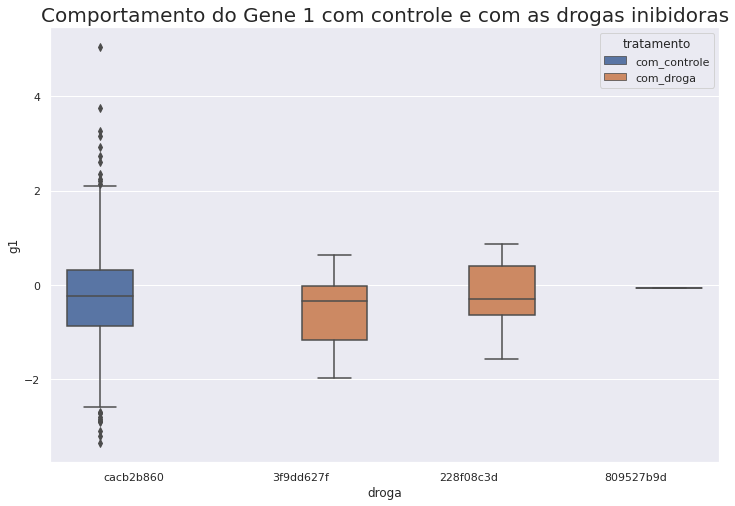

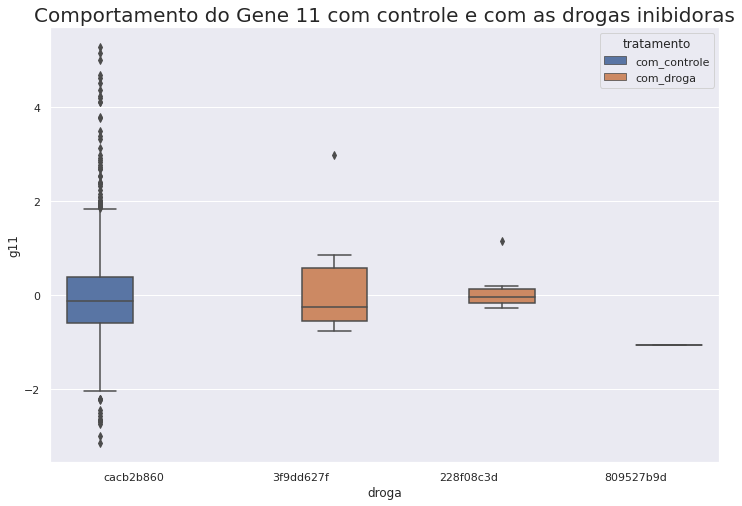

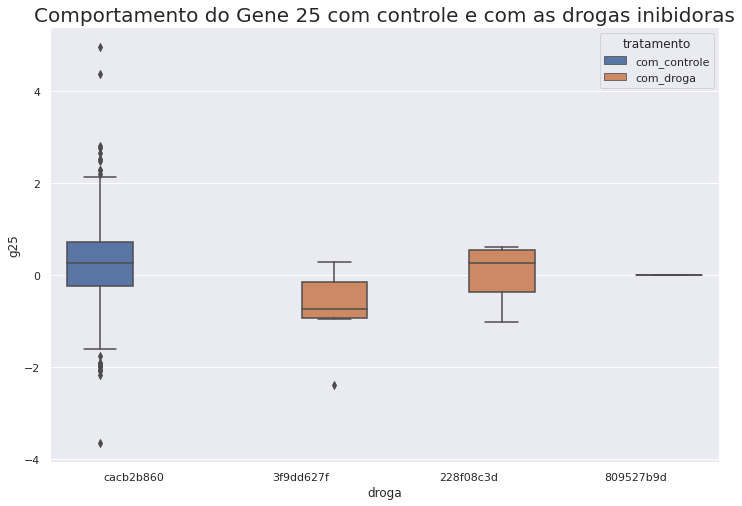

In [19]:
#análise gráfica de genes - Boxplot
genes = [1, 11, 25, 36, 42]

for gene in genes:
  plt.figure(figsize=(12,8))
  ax = sns.boxplot(data=comparativo, y=f'g{gene}', x='droga', hue='tratamento')
  ax.set_title(f'Comportamento do Gene {gene} com controle e com as drogas inibidoras', fontdict={'fontsize':20});


Podemos ver que, apesar de ser perceptível a ação dos compostos nos genes escolhidos, **não temos um padrão claro de atuação na expressão gênica destes genes específicos**. Para determinar essa atuação, uma vez que contamos com muitas variáveis, vamos usar o **Aprendizado de Máquina**.

Mas antes, queremos definir apenas se um determinado composto ativa ou não um inibidor. Para isso vamos criar uma coluna chamada **"ativado"**, na qual os compostos que ativaram inibidores receberão o valor "True" e os compostos que não ativaram receberão o valor "False".

In [20]:
#criando minha coluna alvo
experimentos['ativado'] = experimentos['activated_inhibitors'] != 0
experimentos.head()

id tratamento  tempo dose      droga      g0      g1      g2  \
0  id_000644bb2  com_droga     24   D1  b68db1d53  1.0620  0.5577 -0.2479   
1  id_000779bfc  com_droga     72   D1  df89a8e5a  0.0743  0.4087  0.2991   
2  id_000a6266a  com_droga     48   D1  18bb41b2c  0.6280  0.5817  1.5540   
3  id_0015fd391  com_droga     48   D1  8c7f86626 -0.5138 -0.2491 -0.2656   
4  id_001626bd3  com_droga     72   D2  7cbed3131 -0.3254 -0.4009  0.9700   

       g3      g4      g5      g6      g7      g8      g9     g10     g11  \
0 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530   
1  0.0604  1.0190  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201   
2 -0.0764 -0.0323  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631   
3  0.5288  4.0620 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584   
4  0.6919  1.4180 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121   

      g12     g13     g14     g15     g16     g17     g18     g19     g20  \
0  0.5574 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688   
1 -0.0958  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449   
2 -0.0366 -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799   
3 -0.8511 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200   
4 -0.9577  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330   

      g21     g22     g23     g24     g25     g26     g27     g28     g29  \
0 -1.1360 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819   
1 -0.1646 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161   
2 -0.8181 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870   
3 -1.1580 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890   
4 -0.2685  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965   

      g30     g31     g32     g33     g34     g35     g36     g37     g38  \
0  0.2934 -0.5584 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119   
1 -0.0499 -0.2627  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568   
2 -1.8530  0.6069  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470   
3 -0.7575  0.0881 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900   
4 -0.0712  0.6389  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888   

      g39     g40     g41     g42     g43     g44     g45     g46     g47  \
0 -0.2162 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251   
1 -0.0455  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615   
2  1.0310  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615   
3 -0.3814 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747   
4 -0.0848  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416   

      g48     g49     g50     g51     g52     g53     g54     g55     g56  \
0  0.0350  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750   
1  0.1710 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328   
2 -0.4983  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540   
3 -0.4851  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936   
4 -0.3780 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180   

      g57     g58     g59     g60     g61     g62     g63     g64     g65  \
0  0.2263  0.5790  0.9588  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251   
1  0.4759  0.3249 -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948   
2  0.0621 -0.1757 -1.4370  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280   
3  0.4331  0.0899 -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977   
4  1.2130  0.7709  0.6745  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392   

      g66     g67     g68     g69     g70     g71     g72     g73     g74  \
0  0.1670 -0.4195  0.6551 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406   
1 -0.8026  0.0954 -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008   
2 -0.0292  0.0939  0.5916  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708   
3

In [21]:
#verificando quantos experimentos ativam inibidores
experimentos['ativado'].value_counts(normalize=True)

False    0.667423
True     0.332577
Name: ativado, dtype: float64

In [22]:
#quantos compostos nós temos no dataset?
experimentos['droga'].nunique()

3289

In [23]:
#verificando quantos compostos ativam inibidores
experimentos.query('ativado == True')['droga'].nunique()

1006

Pudemos ver que  $33\%$ dos experimentos ativaram **mecanismos inibidores**, representando $1006$ dos $3289$ compostos testados. Vamos tentar visualizar a distribuição de alguns genes e respostas celulares comparando os experimentos que ativaram mecanismos inibidores com os que não ativaram



In [24]:
#genes e tipos celulares escolhidos aleatoriamente apenas para visualização amostral
genes = ['g0', 'g20', 'g42', 'g50', 'g172']
tipos_celulares = ['c32','c42', 'c43','c51', 'c66', 'c99']

#### **COMPARANDO A DISTRIBUIÇÃO DAS RESPOSTAS CELULARES EM UMA AMOSTRA DE TIPOS CELULARES ENTRE COMPOSTOS QUE ATIVAM INIBIDORES E COMPOSTOS QUE NÃO OS ATIVAM**

Pudemos observar que as respostas celulares dos compostos que ativam mecanismos inibidores tendem a ter uma **representação maior no valor -10** do que aqueles que não os ativam

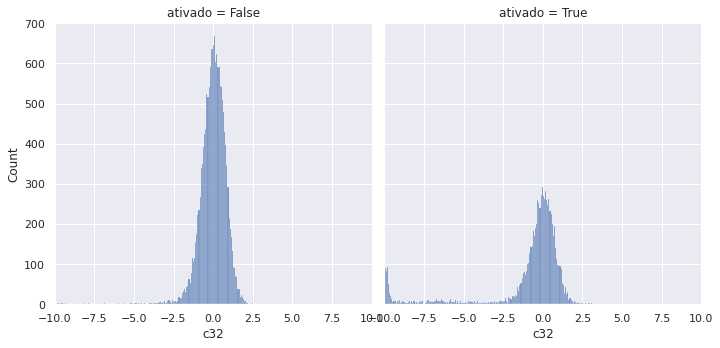

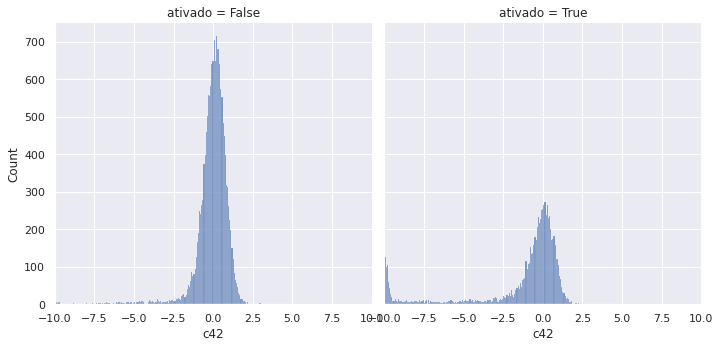

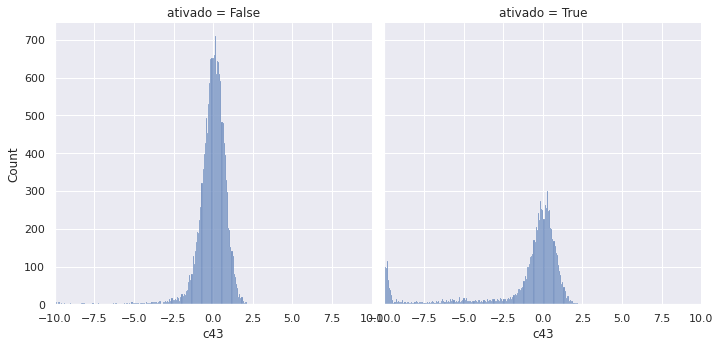

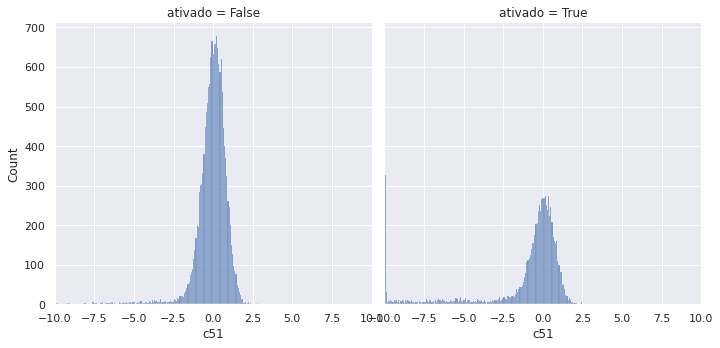

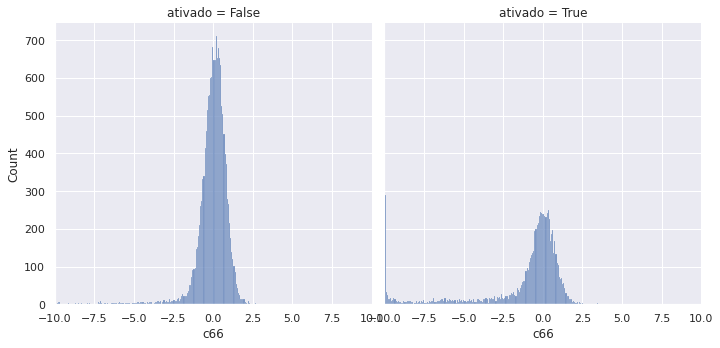

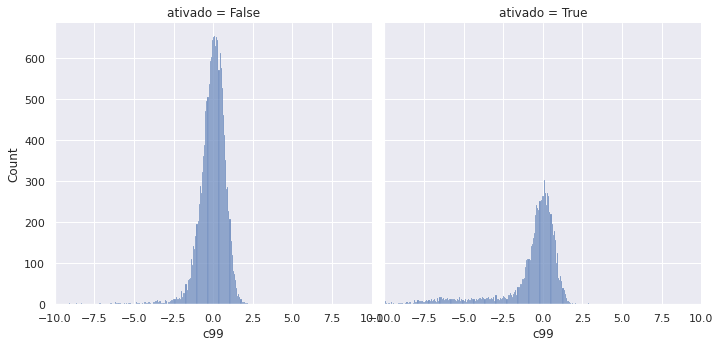

In [25]:
#criando uma análise gráfica para um grupo de tipos celulares
for celula in tipos_celulares:
  sns.displot(data=experimentos, x=celula, col='ativado')
  plt.xlim(-10,10)
  

#### **COMPARANDO A DISTRIBUIÇÃO DAS EXPRESSÕES GENÉTICAS EM UMA AMOSTRA DE GENES ENTRE COMPOSTOS QUE ATIVAM INIBIDORES E COMPOSTOS QUE NÃO OS ATIVAM**

Podemos ver que a cauda  da curva dos compostos que ativam mecanismos inibidores é maior do lado esquerdo do que os compostos que não os ativam, pelo menos para os genes escolhidos.

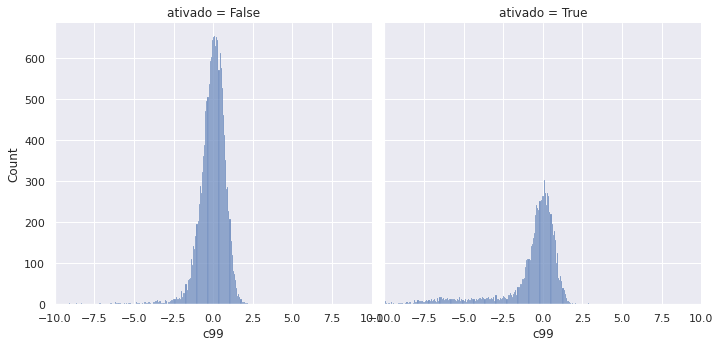

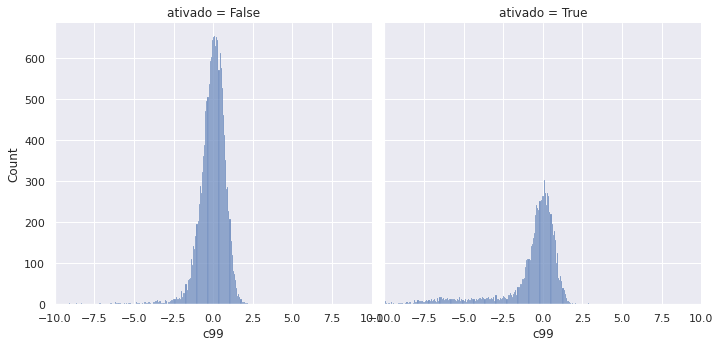

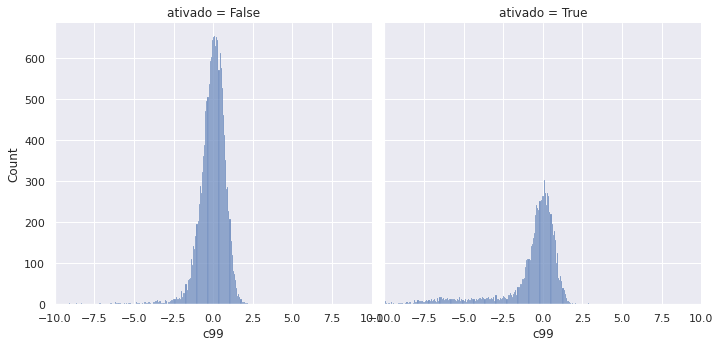

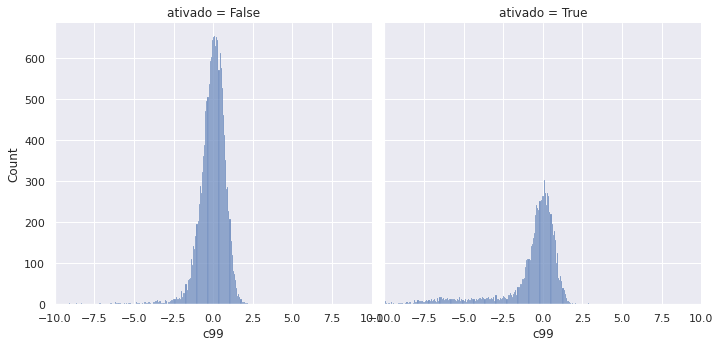

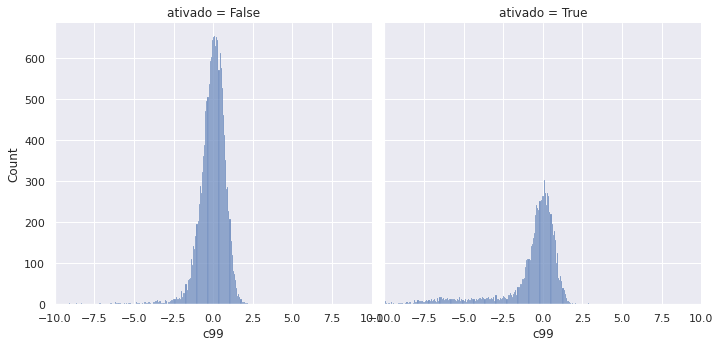

In [26]:
for gene in genes:
  sns.displot(data=experimentos, x=celula, col='ativado')
  plt.xlim(-10,10)


#### **PROFILING E SWEETVIZ**

Uma análise exploratória completa fica prejudicada em função do tempo, portanto vamos usar mecanismos de profiling (como o pandas profiling e o SweetViz para reduzir a complexidade. Estes estudos serão feitos num notebook separado, mas aqui estão os resultados mais interessantes:

Já no início do relatório, a lib nos traz informações importantes sobre nosso conjunto de dados, como **quantidade de linhas**, se há **dados duplicados**, quanto ocupa de **memória**, quantas variáveis temos e o **tipo destas variáveis** (se categóricas ou numéricas).

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/sweetviz_base.PNG?raw=true'>

Uma função importante deste relatório é podes **escolher a variável alvo**, pois recebemos as análises com base neste alvo. Aqui, no caso, escolhemos a coluna **ativado** como nosso alvo, e podemos ver qual a proporção de cada tipo de resposta temos de cada uma das classes.

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/sweetviz_define_alvo.PNG?raw=true'>

A partir daí, o relatório nos mostra a **relação entre a cada variável e seu alvo**. Neste exemplo, ele nos mostra qual a proporção de experimentos que ativaram mecanismos inibidores para cada valor encontrado na resposta celular do tipo de célula 48, e **podemos ver uma correlação negativa clara na linha criada pelo gráfico** abaixo. Esta informação nos leva a crer que esta pode ser uma boa variável para usarmos em nosso projeto de aprendizado de máquina.

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/acao_c48.PNG?raw=true' height='400'>

Já a ação no gene 70 é mista, tendo **picos tanto nas expressões genéticas negativas quanto positivas**. Este é um dos muitos casos em que as proporções não seguem uma tendência clara, **exceto pelo fato de que todas tendem a ter a menor proporção de dados no ponto 0.**

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/acao_g_70.PNG?raw=true' height='400'>

Temos ainda a evidência de que **mecanismos inibidores podem ter efeitos opostos na expressão genética**, a depender do gene, como fica claro quando comparamos o g96 e o g97

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/compara_diferencas.PNG?raw=true'>

Ou **efeitos muito similares**, como é o caso nos genes g24 e g25

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/compara_g24_g25.PNG?raw=true'>








**PANDAS PROFILING**

Já o Pandas Profiling uma ferramenta poderosa para encontrarmos dados estatísticos sobre as variáveis. Nela, pude verificar, por exemplo, a **distribuição de dados** para todas as variáveis.

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/profiling_exemplo.PNG?raw=true'>

Outra função interessante é a de **avisos**, sobre informações nos dados que podem causar problemas num modelo de machine learning, tais como **dados únicos, dados com alta correlação, dados com muitos zeros**, etc. 

<img src='https://github.com/ClarisseAlvarenga/imersao-dados-desafio-final/blob/main/Imagens/warnings.PNG?raw=true'>

O Pandas Profiling ainda pode trazer dados de correlação e Scatterplots de cruzamento entre os dados. No entanto, a inclusão desses parâmetros deixou a função muito lenta, com mais de 3 horas para sua execução, motivo pelo qual decidimos pela versão mínima da função



## **PRE-PROCESSAMENTO DE DADOS E FEATURE SELECTION**

#### **EXCLUSÃO DE COLUNAS**

Para dar continuidade ao nosso estudo e preparar os dados para o algoritmo de aprendizado de máquina, vamos excluir algumas colunas que podem influenciar o modelo por serem variáveis únicas, ou variáveis que são tendenciosas. 

Neste caso, vamos transformar a variável **id** em índice, pois ela é única por observação, vamos excluir a variável **'activated_inhibitor'**, pois ela define nossa variável alvo e deixaria nosso modelo enviesado, sem responder a pergunta que temos, de definir o composto inibidor por sua assinatura genética.

Nossa hipótese é que podemos determinar se houve ativação de um mecanismo inibidor usando como base a assinatura genética e os tipos celulares como variáveis, portanto vamos excluir também as variáveis: **droga, tratamento,tempo e dose**

In [27]:
#transformando a variável id em índice
experimentos.set_index('id', inplace=True)

In [28]:
#excluindo as colunas tratamento, tempo, dose,droga e activated_inhibitors
dados_expressao = experimentos.drop(['tratamento', 'tempo', 'dose','droga', 'activated_inhibitors'], axis=1)

In [29]:
dados_expressao.head()

g0      g1      g2      g3      g4      g5      g6      g7  \
id                                                                             
id_000644bb2  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326   
id_000779bfc  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341  0.3372   
id_000a6266a  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715  0.2155   
id_0015fd391 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095 -1.9590  0.1792   
id_001626bd3 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244 -0.2800 -0.1498   

                  g8      g9     g10     g11     g12     g13     g14     g15  \
id                                                                             
id_000644bb2  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789 -0.6528   
id_000779bfc -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803  0.2250   
id_000a6266a  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057 -0.3278   
id_0015fd391 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690  0.8183   
id_001626bd3 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042  0.1970   

                 g16     g17     g18     g19     g20     g21     g22     g23  \
id                                                                             
id_000644bb2 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940   
id_000779bfc  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372   
id_000a6266a  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307   
id_0015fd391 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004   
id_001626bd3  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057   

                 g24     g25     g26     g27     g28     g29     g30     g31  \
id                                                                             
id_000644bb2  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584   
id_000779bfc  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627   
id_000a6266a  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069   
id_0015fd391 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881   
id_001626bd3  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389   

                 g32     g33     g34     g35     g36     g37     g38     g39  \
id                                                                             
id_000644bb2 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
id_000779bfc  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
id_000a6266a  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
id_0015fd391 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
id_001626bd3  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

                 g40     g41     g42     g43     g44     g45     g46     g47  \
id                                                                             
id_000644bb2 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251   
id_000779bfc  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615   
id_000a6266a  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615   
id_0015fd391 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747   
id_001626bd3  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416   

                 g48     g49     g50     g51     g52     g53     g54     g55  \
id                                                                             
id_000644bb2  0.0350  0.4233 -0.1221 -0.4927  0.6119  0.4715 -0.0351 -0.1605   
id_000779bfc  0.1710 -0.8900  1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231   
id_000a6266a -0.4983  0.4552 -0.0978 -0.2661  0.6058  0.2686 -0.6191 -0.4444   
id_0015fd391 -0.4851  0.6636 -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240   
id_001626bd3 -0.3780 -0.8147 -0.0803 -0.3818  0.6877  0.0000  0.1776  1.1320   

                 g56     g57     g58     g59     g60     g61     g62     g63  \
id         

#### **ANÁLISE DE CORRELAÇÃO**

Vamos analisar a correlação entre as variáveis explicativas 

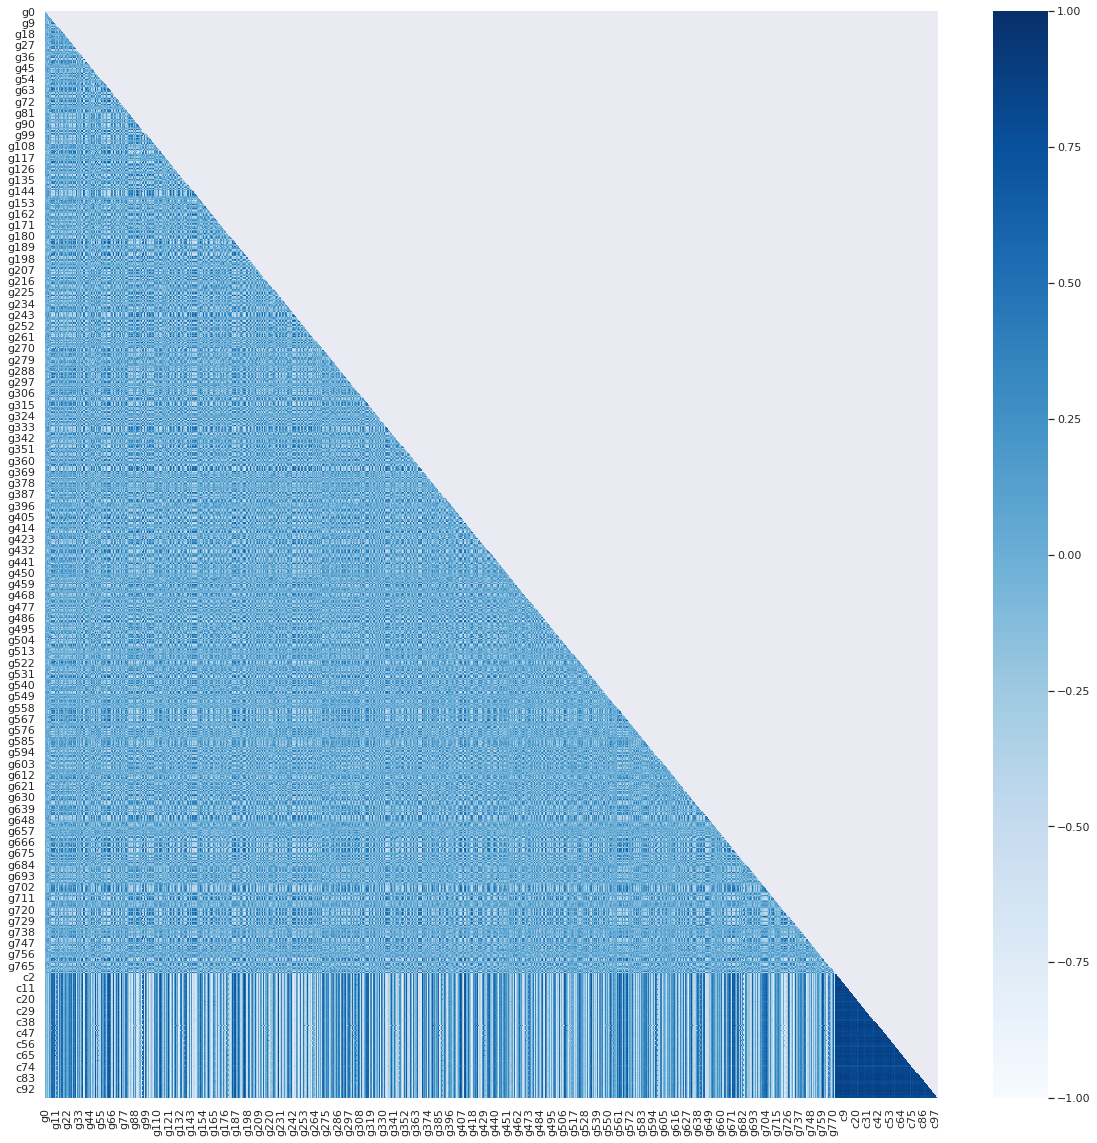

In [30]:
#calculando a correlaçao
corr = dados_expressao.drop('ativado',axis=1).corr()
#usando a função plota_correlação criada para plotar os dados
plota_correlacao(corr, False)

Apesar de ser um gráfico de **difícil visualização**, podemos ver que há uma **alta correlação entre as variáveis de tipos celulares**. Vamos reduzir a visualização para ver apenas essas colunas:

In [31]:
#reduzindo a precisão do cálculo para duas casas decimais, e usando o pandas style pra fazer um heatmap no próprio dataframe
with pd.option_context('display.precision', 2):
    s = (corr.loc[corr.index.str.startswith('c'), corr.columns.str.startswith('c')].style.background_gradient(cmap='Blues'))
s

Variáveis com alta correlação entre si tendem a confundir o algoritmo classificador, portanto vamos excluir todas as colunas que possuam mais de 0.80 de correlação, o que deve excluir a maior parte das colunas de tipos celulares

In [32]:
#Separando apenas o triângulo superior das correlações, para evitar repetição de valores e excluindo assim os cruzamentos das colunas com elas mesmas.
triangulo_superior_correlacao = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
#escolhendo as colunas com mais de 0.85 de correlação
colunas_a_excluir = [column for column in triangulo_superior_correlacao.columns if any(triangulo_superior_correlacao[column] > 0.80)]
print(colunas_a_excluir)

['g50', 'g72', 'g195', 'g228', 'g257', 'g406', 'g410', 'g417', 'g460', 'g489', 'g569', 'g672', 'g744', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70', 'c71', 'c72', 'c73', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99']


In [33]:
#excluindo as colunas com alta correlação
dados_expressao = dados_expressao.drop(colunas_a_excluir,axis=1)

In [34]:
#verificando quantas colunas sobraram
dados_expressao.shape

(23814, 764)

#### **RODANDO UM ALGORITMO DE ESCOLHA DE FEATURES COM BASE NUM MODELO**

Contra nossa expectativa, **nosso algoritmo excluiu algumas expressões genéticas**. Vamos agora pegar nosso dataset resultante e verificar se há alguma variável ou conjunto de variáveis que explique melhor a assinatura de um mecanismo inibidor. Para isso vamos usar o método [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel), da biblioteca SKLearn, que seleciona as variáveis baseadas na importância que um modelo dá para as variáveis:



Para isso, preciso alterar a minha variável alvo para binário:

In [35]:
#definindo que False será 0 e True = 1
mapa = {
    False: 0,
    True: 1
}
#alterando os dados na coluna
dados_expressao['ativado'] = dados_expressao['ativado'].replace(mapa)

In [36]:
dados_expressao.head()

g0      g1      g2      g3      g4      g5      g6      g7  \
id                                                                             
id_000644bb2  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326   
id_000779bfc  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341  0.3372   
id_000a6266a  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715  0.2155   
id_0015fd391 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095 -1.9590  0.1792   
id_001626bd3 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244 -0.2800 -0.1498   

                  g8      g9     g10     g11     g12     g13     g14     g15  \
id                                                                             
id_000644bb2  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789 -0.6528   
id_000779bfc -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803  0.2250   
id_000a6266a  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057 -0.3278   
id_0015fd391 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690  0.8183   
id_001626bd3 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042  0.1970   

                 g16     g17     g18     g19     g20     g21     g22     g23  \
id                                                                             
id_000644bb2 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940   
id_000779bfc  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372   
id_000a6266a  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307   
id_0015fd391 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004   
id_001626bd3  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057   

                 g24     g25     g26     g27     g28     g29     g30     g31  \
id                                                                             
id_000644bb2  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584   
id_000779bfc  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627   
id_000a6266a  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069   
id_0015fd391 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881   
id_001626bd3  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389   

                 g32     g33     g34     g35     g36     g37     g38     g39  \
id                                                                             
id_000644bb2 -0.0916 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162   
id_000779bfc  0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455   
id_000a6266a  0.4290  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310   
id_0015fd391 -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814   
id_001626bd3  0.6674 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848   

                 g40     g41     g42     g43     g44     g45     g46     g47  \
id                                                                             
id_000644bb2 -0.0347 -0.2566 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251   
id_000779bfc  0.1194 -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615   
id_000a6266a  0.3477 -0.5561  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615   
id_0015fd391 -0.7229 -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747   
id_001626bd3  0.1302  0.1224  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416   

                 g48     g49     g51     g52     g53     g54     g55     g56  \
id                                                                             
id_000644bb2  0.0350  0.4233 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750   
id_000779bfc  0.1710 -0.8900 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328   
id_000a6266a -0.4983  0.4552 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540   
id_0015fd391 -0.4851  0.6636 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936   
id_001626bd3 -0.3780 -0.8147 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180   

                 g57     g58     g59     g60     g61     g62     g63     g64  \
id         

In [37]:
#Separando as variáveis explicativas da variável alvo
X, y = dados_expressao.drop(['ativado'], axis=1), dados_expressao['ativado'].astype('int')
# Criando o modelo base para seleção de features
rf = RandomForestClassifier(random_state=17714)

In [38]:
#conferindo o tipo de alvo de uma variável
type_of_target(y)

'binary'

In [59]:
#usando o SelectFromModel para definir as variáveis ideais para o nosso problema. 
#Usamos o modelo Random Forest sem nenhum ajuste de parâmetros além do random_state como modelo base
colunas_a_manter = selecao_features_por_modelo(X,y,rf)

Optimal number of features :coluna    142
bool        1
dtype: int64


In [91]:
#conferindo quais foram as features escolhidas pelo modelo
colunas_a_manter.query('bool == True')

coluna  bool
0       g0  True
3       g3  True
8       g8  True
12     g12  True
20     g20  True
..     ...   ...
748   g761  True
750   g763  True
756   g769  True
761    c58  True
762    c74  True

[142 rows x 2 columns]

In [61]:
#Criando um x específico apenas com estas variáveis
X_sfm = X[list(colunas_a_manter.query('bool == True').coluna)]

In [62]:
#checando as variáveis escolhidas pelo modelo
X_sfm.head()

g0      g3      g8     g12     g20     g22     g28     g29  \
id                                                                             
id_000644bb2  1.0620 -0.6208  0.5548  0.5574 -0.5688 -1.1880 -0.2853  0.5819   
id_000779bfc  0.0743  0.0604 -0.4047 -0.0958  0.9449 -0.2657 -0.4216 -0.1161   
id_000a6266a  0.6280 -0.0764  0.0065 -0.0366 -0.0799 -1.5320 -0.0437  1.2870   
id_0015fd391 -0.5138  0.5288 -0.1321 -0.8511  2.1200 -0.7191 -0.2479 -1.0890   
id_001626bd3 -0.3254  0.6919 -0.8789 -0.9577 -0.3330  0.7649 -1.2090  0.2965   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed  0.1394 -0.5080 -0.4726 -0.4532  0.8550  0.5541 -0.6686  0.2326   
id_fffb70c0c -1.3260  0.9905  0.5112 -0.2140 -0.2182  0.0749  0.0880  0.1842   
id_fffc1c3f4  0.3942 -0.7389 -0.0340  0.1729  0.1521  0.2310  0.4516  1.2300   
id_fffcb9e7c  0.6660  0.2044  0.4299  2.2700 -0.7805  0.3440  0.8771 -2.6560   
id_ffffdd77b -0.8598  0.7952  3.0790  2.9780 -0.1919 -1.4050  0.1599 -0.4250   

                 g30     g33     g34     g36     g37     g41     g47     g51  \
id                                                                             
id_000644bb2  0.2934 -0.3010 -0.1537  0.2965 -0.5055 -0.2566 -0.0251 -0.4927   
id_000779bfc -0.0499 -0.2483  0.2655  0.1656  0.5300 -0.3958 -0.3615 -0.5036   
id_000a6266a -1.8530  0.1783  0.0018  0.1256 -0.1219 -0.5561 -0.7615 -0.2661   
id_0015fd391 -0.7575  0.8745  0.5787 -1.6720 -1.2690 -0.0010  0.0747 -0.6035   
id_001626bd3 -0.0712 -0.0783  1.1740 -1.4470  1.0620  0.1224 -0.9416 -0.3818   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed  0.6456 -0.6320  0.7166  0.3686 -0.1565  1.3410 -0.3036 -0.3948   
id_fffb70c0c  0.1835 -0.0491  0.9543  0.0819  0.1586 -0.8834  0.8523 -0.3773   
id_fffc1c3f4 -0.1949 -0.0040 -0.3086 -0.5222 -1.1470 -0.2369 -0.2351  0.7447   
id_fffcb9e7c -0.2000 -0.0248 -0.0927 -2.7180 -5.3160  0.0329  2.7900  0.4567   
id_ffffdd77b  0.3591 -0.2005 -1.8340  0.5145 -0.9913 -0.7888 -1.3550  0.3169   

                 g52     g58     g62     g63     g75     g85     g91     g94  \
id                                                                             
id_000644bb2  0.6119  0.5790  0.6611 -0.3136 -0.6332  0.0190 -1.1230  0.7017   
id_000779bfc -0.2277  0.3249 -0.1087  1.0350 -0.5857 -0.3979 -0.3854 -0.0188   
id_000a6266a  0.6058 -0.1757 -0.3334 -0.2933 -1.3570 -0.1562  0.4286 -0.6283   
id_0015fd391 -1.3550  0.0899 -1.2100 -1.2340 -3.3210  1.0280  4.9160 -1.4810   
id_001626bd3  0.6877  0.7709  0.1806  1.3480 -0.7868 -0.1491  0.8025 -0.1518   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed  1.1560 -0.2057 -0.4110 -0.1667  0.1710 -1.4720 -0.2432 -0.4658   
id_fffb70c0c -0.2667 -0.0196 -1.0710 -0.0422  0.0452  0.9419 -0.5028 -0.5828   
id_fffc1c3f4 -0.0546  0.0359  0.8449  0.1728  0.8459  1.0680 -2.3820 -0.5473   
id_fffcb9e7c -1.6260 -6.2950  2.5190 -1.9730  3.3020  1.0250  0.6629  1.0920   
id_ffffdd77b  0.3251  0.5438 -2.2130 -0.7770 -3.6610  1.4340  2.5210 -0.6398   

                 g97     g98    g100    g106    g107    g114    g117    g121  \
id                                                                             
id_000644bb2  0.4527  0.5455 -0.5364  0.1593 -0.6998 -0.9902 -0.0348  1.2880   
id_000779bfc  0.4300 -0.3965  0.7129 -0.1630 -0.2356  0.8842  0.0268  0.0232   
id_000a6266a  0.0955 -0.3061 -0.7646 -0.9601 -0.2600 -0.3827 -0.4446 -0.9627   
id_0015fd391 -1.7220  0.0892  1.0390 -0.1619 -0.9467  0.2815 -1.8970 -1.3960   
id_001626bd3 -0.2334  0.2345  0.0968 -0.8521 -0.2801  0.8598  0.0481  0.7353   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed -1.2870 -0.2978 -0.6344 -0.0340  2.5000  1.4810 -0.8059 -0.1772   
id_fffb70c0c  0.5167 -0.0555 -0.5803  0.0604 -0.2564  1.0880 -0.9882 -0.1508   
id_fffc1c3f4 -0.8123  0.6885 -0.2501 -1.0590 -0.6912  1.6250 -0.1750  0.2435   
id_fffcb9e7c  1

## **MACHINE LEARNING - MODELOS**


Passamos pelo processo de análise exploratória e de escolha de features, mas para sabermos se nossos modelos realmente vão gerar valor para a pesquisa, precisamos testar nossos dados com alguns modelos base. Para isso vamos usar o DummyClassifier. Ele servirá como linha base para definir a qualidade de nossos modelos.

Como critério de avaliação deste e dos demais modelos, a medida que vamos prestar mais atenção será o recall, constante do classification_report, pois ele mede, segundo a própria [documentação](https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html#:~:text=percent%20was%20correct%3F%E2%80%9D-,recall,true%20positives%20and%20false%20negatives) do sci-kit:

"*a completude do classificador. A habilidade de um classificador encontrar corretamente todas as instâncias positivas. Para cada classe é definida como a razão verdadeiros positivos pela soma de verdadeiros positivos e falsos negativos. Dito de outra forma*, "**para todas as instâncias que eram positivas, qual o percentual que foi classificado corretamente**?""


Para começar nossos trabalhos no entanto, a primeira coisa que devemos fazer é dividir nossos dados entre dados de treino e teste, para que possamos avaliar nossos modelos. Para isso, vamos fazer duas divisões: Uma usando todas as variáveis do dataset após as exclusões manuais, e uma usando apenas as variáveis escolhidas pelo algoritmo de seleção

In [64]:
#sets de dados completos
X_base_train, X_base_test, y_base_train, y_base_test = divide_treino_teste(X,y)

### **DIVIDINDO OS DADOS ENTRE TREINO E TESTE**


In [65]:
#dados escolhidos pelo SelectFromModel
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = divide_treino_teste(X_sfm,y)

### **MODELO BASE - DUMMY CLASSIFIER**

Este modelo vai testar os dados escolhendo como estratégia o valor mais frequente da variável alvo. 

In [70]:
modelo_dummy = DummyClassifier(strategy='most_frequent')
modelo_treinado_dummy, previsoes_dummy,avalia_dummy = treina_e_avalia_classificador(modelo_dummy, 
                                                                                    X_base_train, X_base_test, y_base_train, y_base_test )

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      3179
           1       0.00      0.00      0.00      1584

    accuracy                           0.67      4763
   macro avg       0.33      0.50      0.40      4763
weighted avg       0.45      0.67      0.53      4763



### **MODELO BASE COM TODAS AS FEATURES**

In [71]:
#testando o modelo usado para definir as features
modelo_treinado_rf, previsoes_rf,avalia_rf = treina_e_avalia_classificador(rf,X_base_train, X_base_test, y_base_train, y_base_test )

              precision    recall  f1-score   support

           0       0.76      0.96      0.84      3179
           1       0.82      0.38      0.52      1584

    accuracy                           0.77      4763
   macro avg       0.79      0.67      0.68      4763
weighted avg       0.78      0.77      0.74      4763



Vemos que nosso modelo base se acerta melhor que o modelo Dummy, no entanto, ele ainda se confunde muito na categoria que queremos definir, tendendo a escolher que não ativa inibidores nos casos que ativa, mais vezes do que acerta a categoria. Vamos ver se com as features escolhidas ele se ajusta melhor

In [72]:
# testando com as features escolhidas:
modelo_treinado_rf, previsoes_rf,avalia_rf = treina_e_avalia_classificador(rf,X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test )

              precision    recall  f1-score   support

           0       0.76      0.95      0.85      3179
           1       0.81      0.40      0.54      1584

    accuracy                           0.77      4763
   macro avg       0.79      0.68      0.69      4763
weighted avg       0.78      0.77      0.74      4763



Nosso modelo base se saiu melhor com as features escolhidas pelo algoritmo (como esperado), portanto esse será o set de dados utilizado para aprimorar nossos modelos daqui para frente

In [85]:
#recriando a divisão de dados, usando as variáveis escolhidas
X_train, X_test, y_train, y_test = divide_treino_teste(X_sfm,y)

In [74]:
#para uso do pycaret, vamos reunir o X_treino e o y_treino para gerarmos um dataset de análise
#criando uma base unificada de treino, para usarmos o PyCaret
dados_treino = X_train
dados_treino['ativado'] = y_train

### **ESCOLHENDO MODELOS USANDO O PYCARET**

Para analisar qual modelo se ajusta melhor a esses dados, vamos usar mais uma lib do python chamada [PyCaret](https://pycaret.readthedocs.io/en/latest/api/classification.html). Esta biblioteca do Python performa várias tarefas de Machine Learning, entre elas o pré-processamento dos dados e geração de modelos de aprendizado de dados. Neste caso, vamos rodar algumas funções com nossos dados de treino. 

Esta biblioteca cria uma nova divisão de dados de treino e teste, usando ainda o [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) para fazer a validação cruzada dos dados, nos diversos testes que podemos fazer. Apesar de podermos gerar o modelo totalmente dentro da biblioteca, neste caso vamos aproveitar a biblioteca para fazer uma comparação de modelos. Vamos usar para isto duas funções:
o setup (que prepara os dados para uso da biblioteca) e o compare_models (que compara os modelos).

De acordo com a documentação da biblioteca, estes serão os modelos que o PyCaret poderá testar na classificação:

ID|	Name
---|---
‘lr’|	Logistic Regression
‘knn’|	K Nearest Neighbour
‘nb’|	Naives Bayes
‘dt’|	Decision Tree Classifier
‘svm’|	SVM – Linear Kernel
‘rbfsvm’|	SVM – Radial Kernel
‘gpc’|	Gaussian Process Classifier
‘mlp’|	Multi Level Perceptron
‘ridge’|	Ridge Classifier
‘rf’|	Random Forest Classifier
‘qda’|	Quadratic Discriminant Analysis
‘ada’|	Ada Boost Classifier
‘gbc’|	Gradient Boosting Classifier
‘lda’|	Linear Discriminant Analysis
‘et’|	Extra Trees Classifier
‘xgboost’|	Extreme Gradient Boosting
‘lightgbm’|	Light Gradient Boosting
‘catboost’|	CatBoost Classifier

In [75]:
#como já preprocessamos nossos dados, não o faremos novamente nesta base
setup(data= dados_treino, target= 'ativado', session_id=17714, preprocess=False)

Description             Value
0              session_id             17714
1                  Target           ativado
2             Target Type            Binary
3           Label Encoded        0: 0, 1: 1
4           Original Data      (19051, 143)
5          Missing Values             False
6        Numeric Features               142
7    Categorical Features                 0
8   Transformed Train Set      (13335, 142)
9    Transformed Test Set       (5716, 142)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                10
14               CPU Jobs                -1
15                Use GPU             False
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              e701
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

('e701', [('Setup Config',               Description             Value
   0              session_id             17714
   1                  Target           ativado
   2             Target Type            Binary
   3           Label Encoded        0: 0, 1: 1
   4           Original Data      (19051, 143)
   5          Missing Values             False
   6        Numeric Features               142
   7    Categorical Features                 0
   8   Transformed Train Set      (13335, 142)
   9    Transformed Test Set       (5716, 142)
   10     Shuffle Train-Test              True
   11    Stratify Train-Test             False
   12         Fold Generator   StratifiedKFold
   13            Fold Number                10
   14               CPU Jobs                -1
   15                Use GPU             False
   16         Log Experiment             False
   17        Experiment Name  clf-default-name
   18                    USI              e701
   19          Fix Imbalance        

In [77]:
compare_models(sort='recall')

Model  Accuracy     AUC  Recall   Prec.  \
dt               Decision Tree Classifier    0.6506  0.6120  0.4969  0.4750   
xgboost         Extreme Gradient Boosting    0.7569  0.7274  0.4243  0.7307   
svm                   SVM - Linear Kernel    0.7277  0.0000  0.4098  0.6458   
lightgbm  Light Gradient Boosting Machine    0.7669  0.7390  0.4019  0.7950   
knn                K Neighbors Classifier    0.7447  0.6841  0.3944  0.7074   
rf               Random Forest Classifier    0.7659  0.7258  0.3865  0.8087   
gbc          Gradient Boosting Classifier    0.7633  0.7305  0.3850  0.7966   
qda       Quadratic Discriminant Analysis    0.7369  0.7030  0.3813  0.6878   
ada                  Ada Boost Classifier    0.7483  0.7067  0.3707  0.7426   
lr                    Logistic Regression    0.7570  0.7146  0.3554  0.8024   
et                 Extra Trees Classifier    0.7598  0.7215  0.3509  0.8258   
lda          Linear Discriminant Analysis    0.7573  0.7159  0.3335  0.8385   
ridge                    Ridge Classifier    0.7570  0.0000  0.3292  0.8445   
nb                            Naive Bayes    0.7317  0.6775  0.3202  0.7145   

              F1   Kappa     MCC  TT (Sec)  
dt        0.4855  0.2213  0.2216     2.882  
xgboost   0.5366  0.3873  0.4136    32.977  
svm       0.4983  0.3247  0.3421     0.441  
lightgbm  0.5337  0.3999  0.4413     1.890  
knn       0.5063  0.3524  0.3798     7.457  
rf        0.5226  0.3924  0.4395    13.335  
gbc       0.5188  0.3864  0.4313    36.665  
qda       0.4903  0.3322  0.3586     0.147  
ada       0.4941  0.3508  0.3885     6.958  
lr        0.4922  0.3627  0.4147     0.185  
et        0.4921  0.3669  0.4247     3.262  
lda       0.4767  0.3551  0.4192     0.286  
ridge     0.4733  0.3530  0.4193     0.044  
nb        0.4419  0.2977  0.3394     0.043

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17714, splitter='best')

              precision    recall  f1-score   support

           0       0.75      0.72      0.73      3179
           1       0.47      0.51      0.49      1584

    accuracy                           0.65      4763
   macro avg       0.61      0.61      0.61      4763
weighted avg       0.65      0.65      0.65      4763



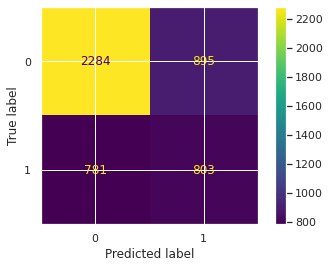

In [86]:
#treinando e avaliando o modelo sugerido pelo Pycaret
modelo_dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17714, splitter='best')
# testando com as features escolhidas:
modelo_treinado_dtc, previsoes_dtc,avalia_dtc = treina_e_avalia_classificador(modelo_dtc,X_train, X_test, y_train, y_test)

Este modelo se saiu melhor na previsão do caso positivo de nossos dados, no entanto erra demais na previsão dos casos negativos. Vamos testar o segundo melhor modelo da análise do pycaret para ver se ele funciona melhor

In [83]:
modelo_xgboost = create_model('xgboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7399  0.7181  0.3770  0.7017  0.4905  0.3364  0.3657
1       0.7511  0.7153  0.4221  0.7110  0.5297  0.3751  0.3987
2       0.7489  0.7293  0.4041  0.7160  0.5166  0.3643  0.3915
3       0.7646  0.7222  0.4357  0.7510  0.5514  0.4068  0.4345
4       0.7429  0.6973  0.4086  0.6908  0.5135  0.3540  0.3766
5       0.7524  0.7274  0.4199  0.7181  0.5299  0.3772  0.4022
6       0.7577  0.7219  0.4266  0.7326  0.5392  0.3900  0.4162
7       0.7704  0.7241  0.4289  0.7819  0.5539  0.4166  0.4506
8       0.7779  0.7640  0.4831  0.7616  0.5912  0.4490  0.4709
9       0.7629  0.7548  0.4367  0.7423  0.5499  0.4033  0.4295
Mean    0.7569  0.7274  0.4243  0.7307  0.5366  0.3873  0.4136
SD      0.0115  0.0182  0.0259  0.0270  0.0261  0.0313  0.0314

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      3179
           1       0.74      0.43      0.55      1584

    accuracy                           0.76      4763
   macro avg       0.75      0.68      0.69      4763
weighted avg       0.76      0.76      0.74      4763



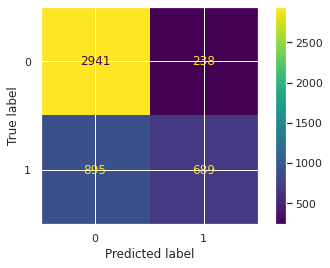

In [88]:
modelo_treinado_xgb, previsoes_xgb,avalia_xgb = treina_e_avalia_classificador(modelo_xgboost,X_train, X_test, y_train, y_test)

Esse modelo se comportou de maneira marginalmente melhor que o nosso modelo base na previsão de inibidores , sendo pior que o DecisionTreeClassifier em determinar a classe positiva, mas **melhor na exclusão dos falsos positivos**. No entanto, ele ainda **gera mais falsos positivos que positivos reais**, ***não sendo ideal a sua implementação.***

#### **MELHORANDO OS HIPERPARÂMETROS DO MODELO**

Vamos tentar **melhorar o modelo**, ajustando seus hiperparâmetros, usando o *tune_model* do *PyCaret*

In [89]:
modelo_xgboost_tunado = tune_model(modelo_xgboost)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7294  0.7112  0.5011  0.6133  0.5516  0.3606  0.3643
1       0.7054  0.7132  0.5237  0.5604  0.5414  0.3248  0.3252
2       0.7174  0.7174  0.5260  0.5825  0.5528  0.3470  0.3480
3       0.7294  0.7212  0.5485  0.6015  0.5738  0.3762  0.3770
4       0.7144  0.7287  0.5260  0.5767  0.5502  0.3416  0.3424
5       0.7487  0.7550  0.5440  0.6444  0.5900  0.4106  0.4137
6       0.7352  0.7329  0.5214  0.6210  0.5669  0.3782  0.3812
7       0.7367  0.7317  0.5192  0.6250  0.5672  0.3803  0.3837
8       0.7382  0.7624  0.6005  0.6073  0.6039  0.4084  0.4084
9       0.7179  0.7079  0.5204  0.5838  0.5502  0.3458  0.3470
Mean    0.7273  0.7282  0.5331  0.6016  0.5648  0.3673  0.3691
SD      0.0125  0.0174  0.0257  0.0243  0.0188  0.0271  0.0275

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      3179
           1       0.61      0.53      0.56      1584

    accuracy                           0.73      4763
   macro avg       0.69      0.68      0.68      4763
weighted avg       0.72      0.73      0.72      4763



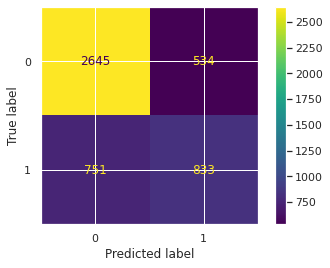

In [90]:
modelo_treinado_tunado, previsoes_tunado,avalia_tunado = treina_e_avalia_classificador(modelo_xgboost_tunado,X_train, X_test, y_train, y_test)

Houve uma melhora significativa entre o modelo padrão e o modelo com hiperparâmetros ajustados, sendo que, entre todos os meus experimentos, este é o **primeiro algoritmo que tem mais positivos verdadeiros que falsos negativos**, ainda que ainda tenhamos um **aumento de falsos positivos**. Vamos rodar o mesmo ajustador de hiperparâmetros, mas desta vez, vamos pedir que ele escolha a melhor performance, uma vez que por padrão, o *tune_model()* escolhe o resultado médio entre os experimentos.

In [92]:
modelo_xgboost_tunado = tune_model(modelo_xgboost, choose_better=True)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7294  0.7112  0.5011  0.6133  0.5516  0.3606  0.3643
1       0.7054  0.7132  0.5237  0.5604  0.5414  0.3248  0.3252
2       0.7174  0.7174  0.5260  0.5825  0.5528  0.3470  0.3480
3       0.7294  0.7212  0.5485  0.6015  0.5738  0.3762  0.3770
4       0.7144  0.7287  0.5260  0.5767  0.5502  0.3416  0.3424
5       0.7487  0.7550  0.5440  0.6444  0.5900  0.4106  0.4137
6       0.7352  0.7329  0.5214  0.6210  0.5669  0.3782  0.3812
7       0.7367  0.7317  0.5192  0.6250  0.5672  0.3803  0.3837
8       0.7382  0.7624  0.6005  0.6073  0.6039  0.4084  0.4084
9       0.7179  0.7079  0.5204  0.5838  0.5502  0.3458  0.3470
Mean    0.7273  0.7282  0.5331  0.6016  0.5648  0.3673  0.3691
SD      0.0125  0.0174  0.0257  0.0243  0.0188  0.0271  0.0275

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      3179
           1       0.74      0.43      0.55      1584

    accuracy                           0.76      4763
   macro avg       0.75      0.68      0.69      4763
weighted avg       0.76      0.76      0.74      4763



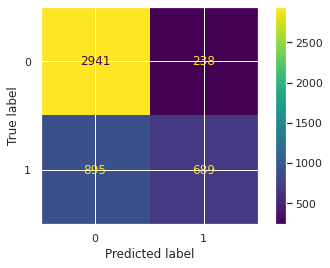

In [93]:
modelo_treinado_tunado, previsoes_tunado,avalia_tunado = treina_e_avalia_classificador(modelo_xgboost_tunado,X_train, X_test, y_train, y_test)

O modelo escolhido optou por acurácia como medida de avaliação, e acabou se saindo pior quando da detecção de casos positivos, gerando mais falsos positivos que positivos verdadeiros. Mas ele se saiu melhor na identificação de casos negativos.

## **CONCLUSÃO**

Esta base de dados de ***Drug Discovery*** é uma das mais fascinantes e complexas bases com as quais trabalhei. Conseguimos perceber que cada uma das variáveis contidas no dataset tem sua importância, e as medidas variam enormemente a depender de seu mecanismo de ação. No entanto, pelos resultados atingidos pelas tentativas de criação de um modelo que previsse corretamente se um mecanismo de ação era do tipo inibidor ou não demonstrou que o agrupamento de vários mecanismos nesta categoria não é tão eficiente quanto minha hipótese levantou.

Talvez seja mais interessante criar um modelo que aprenda a discernir por tipo de inibidor. No entanto neste caso nosso dataset é altamente desbalanceado, e nosso algoritmo teria poucos dados para aprender a avaliar.